This notebook generates a single linear model using dynamic mode decomposition with control


In [436]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

config = dotenv_values(".env")


In [437]:
# Read in data and build data matrices
filepath = config["currentDirectory"] + "data/processedData/processedData_policySeed_0.npz"

Ndata = 200 # number of timesteps worth of data to grab from each file
Nepisodes = 10 # number of episodes worth of data to aggregate into each data matrix

with np.load(filepath) as data:
    stateData = data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']

# Center state and centerline data
stateOffset = stateData[0,:]
stateData = stateData-stateOffset

centerlineOffset = centerlineData[0,:]
centerlineData = centerlineData-centerlineOffset

# Build data matrices
X = np.transpose(stateData[0:Ndata,:])
Xprime = np.transpose(stateData[1:Ndata+1,:])
Upsilon = np.transpose(inputData[0:Ndata,:])
Y = np.transpose(centerlineData[0:Ndata,:])

n = X.shape[0] # size of state space 
l = Upsilon.shape[0] # number of inputs
m = Y.shape[0] # number of outputs


# Preallocate data matrices
X = np.zeros((n,Ndata*Nepisodes))
Xprime = np.zeros((n,Ndata*Nepisodes))
Upsilon = np.zeros((l,Ndata*Nepisodes))
Y = np.zeros((m,Ndata*Nepisodes))


# Read in data and build aggregate data matrices
for i in range(Nepisodes):
    filepath = config["currentDirectory"] + "data/processedData/processedData_policySeed_" + str(i) + ".npz"
    with np.load(filepath) as data:
        stateData = data['stateData']
        inputData = data['inputData']
        centerlineData = data['centerlineData']

    # Center state and centerline data
    stateOffset = stateData[0,:]
    stateData = stateData-stateOffset

    centerlineOffset = centerlineData[0,:]
    centerlineData = centerlineData-centerlineOffset

    # Build data matrices
    X[:,i*Ndata:(i+1)*Ndata] = np.transpose(stateData[0:Ndata,:])
    Xprime[:,i*Ndata:(i+1)*Ndata] = np.transpose(stateData[1:Ndata+1,:])
    Upsilon[:,i*Ndata:(i+1)*Ndata] = np.transpose(inputData[0:Ndata,:])
    Y[:,i*Ndata:(i+1)*Ndata] = np.transpose(centerlineData[0:Ndata,:])


In [438]:
# Form snapshot matrices for DMD

Omega = np.concatenate([X,Upsilon],axis=0)

n = X.shape[0] # size of state space 
l = Upsilon.shape[0] # number of inputs
m = Y.shape[0] # number of outputs

In [449]:
# Decompose snapshot matrices using truncated SVD algorithm
p = 1000# Truncation value for input space
r = 100 # Truncation value for output space

U_tilde,Sigma_tilde,Vh_tilde = randomized_svd(Omega, n_components=p)
Sigma_tilde = np.diag(Sigma_tilde)
U_hat, Sigma_hat, V_hat = randomized_svd(Xprime, n_components=r)
Sigma_hat = np.diag(Sigma_hat)



In [450]:
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_tilde = (U_hat.conj().T)@Xprime@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_tilde = (U_hat.conj().T)@Xprime@(Vh_tilde.conj().T)@(np.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

In [451]:
# #Simulate system state response
# T = 100 # number of timesteps to simulate for 
# x_rs = np.zeros((r,T))
# u_rs = Upsilon[:,0:T]
# for i in range(1,T):
#     x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]

In [452]:
# solve for output matrix from full order system
ys = Y[:,0:10]
X_PI = np.linalg.pinv(X[:,0:10])
C = ys@X_PI
# x_rs_PI = np.linalg.pinv(x_rs) 
# C_tilde = ys@x_rs_PI
# C = np.round(C,decimals=2)

# Plotting Response to Test Set Data

In [453]:
#Simulate system output response with learning set
T = 200 # number of timesteps to simulate for 
x_rs = np.zeros((r,T))
y_rs = np.zeros((m,T))
u_rs = Upsilon[:,0:T]
for i in range(1,T):
    x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]
    y_rs[:,[i]] = C@U_hat@x_rs[:,[i]] # Compute output from FOM output matrix

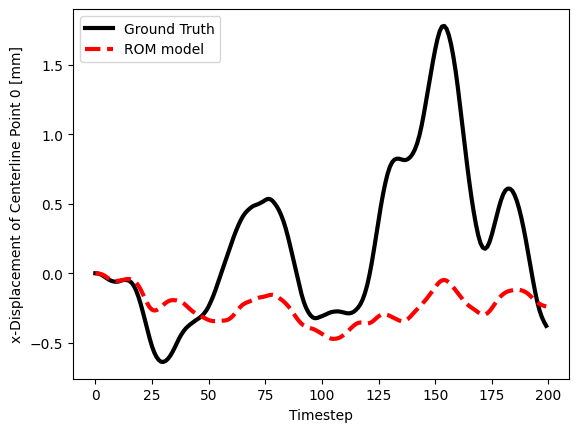

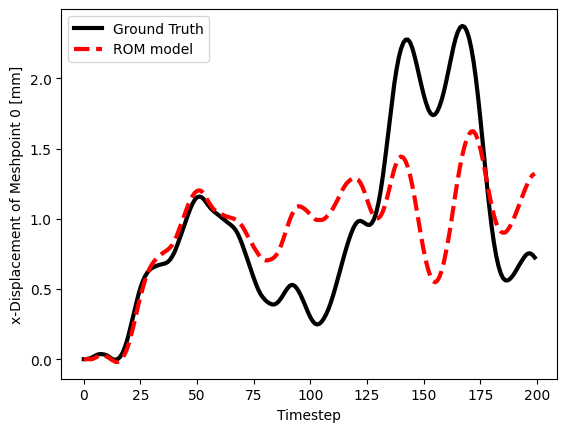

In [454]:
#Plot
plt.plot(range(T),Y[0,0:T], 'k-',lw=3)
plt.plot(range(T),y_rs[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')

plt.show()


# Plot first state values using projection matrix transpose
x_hat = U_hat@x_rs
plt.plot(range(T),X[0,0:T], 'k-',lw=3)
plt.plot(range(T),x_hat[0,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Meshpoint 0 [mm]')
plt.show()

# Verification


In [455]:
# Read in verification data
# Read in data 
testFilepath = config["currentDirectory"] + "data/processedData/processedData_policySeed_49.npz"

with np.load(testFilepath) as data:
    stateData = data['stateData']
    inputData = data['inputData']
    centerlineData = data['centerlineData']

# Center state and centerline data
stateOffset = stateData[0,:]
stateData = stateData-stateOffset

centerlineOffset = centerlineData[0,:]
centerlineData = centerlineData-centerlineOffset

# Build data matrices
X_test = np.transpose(stateData[0:Ndata,:])
Xprime_test = np.transpose(stateData[1:Ndata+1,:])
Upsilon_test = np.transpose(inputData[0:Ndata,:])
Y_test = np.transpose(centerlineData[0:Ndata,:])


In [456]:
##### Verification on test data set #######
T = 200# number of timesteps to simulate for 
x_rs = np.zeros((r,T))
y_rs = np.zeros((m,T))
u_rs = Upsilon_test[:,0:T]
for i in range(1,T):
    x_rs[:,[i]] = A_tilde@x_rs[:,[i-1]] + B_tilde@u_rs[:,[i-1]]
    y_rs[:,[i]] = C@U_hat@x_rs[:,[i]] # Compute output from FOM output matrix


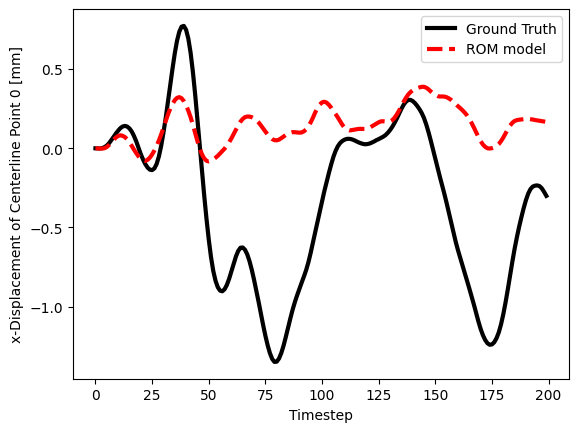

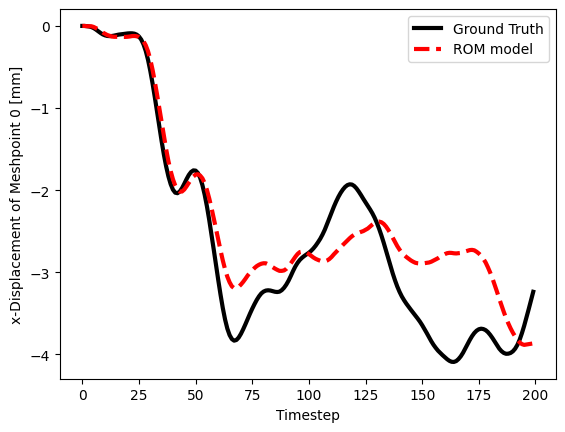

In [457]:
#Plot
outputIndex = 0
plt.plot(range(T),Y_test[outputIndex,0:T], 'k-',lw=3)
plt.plot(range(T),y_rs[outputIndex,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel('x-Displacement of Centerline Point 0 [mm]')
plt.show()

# Plot first state values using projection matrix transpose
x_hat = U_hat@x_rs
plt.plot(range(T),X_test[outputIndex,0:T], 'k-',lw=3)
plt.plot(range(T),x_hat[outputIndex,:],'r--',lw=3)
plt.legend(['Ground Truth','ROM model'])
plt.xlabel('Timestep')
plt.ylabel(f'x-Displacement of Meshpoint {outputIndex} [mm]')
plt.show()


# Generate Animation

MoviePy - Building file /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/visualizations/verification1.gif with imageio.


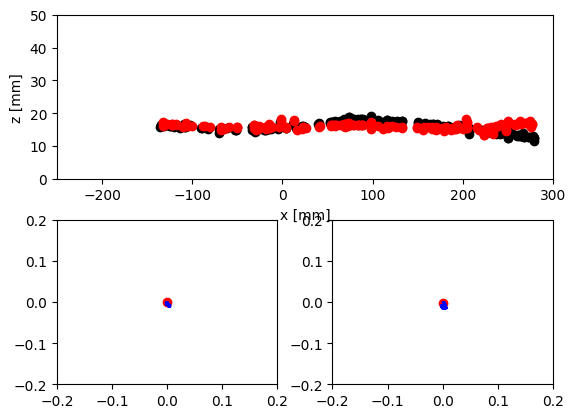

In [458]:
# configure video to be saved
savePath = config["currentDirectory"] +"data/visualizations/" 
# files = dir_list = os.listdir(filepath)
numFrames = 200#np.size(files) 
# Setup figure for plotting data
fig = plt.figure()
gs = mpl.gridspec.GridSpec(2,2,wspace=0.25,hspace=0.25)
# ax = fig.add_subplot(gs[0,:],projection='3d')
ax = fig.add_subplot(gs[0,:])
ax1=fig.add_subplot(gs[1,0])
ax2=fig.add_subplot(gs[1,1])
fps = 40
duration = numFrames/fps



xlim_max = 300
xlim_min = -250 
zlim_max = 50
zlim_min = 0


ulim_max = 0.2
ulim_min = -0.2

def animate(t):
    global Upsilon
    global Y
    global X
    inputData = Upsilon.T
    centerlineData = Y.T + centerlineOffset
    centerlineData_test = Y_test.T + centerlineOffset

    i = int(round(t*fps))

    # Read in data from files
    centerline_frame_groundTruth =np.reshape(centerlineData_test[i,:],(-1,3))
    centerline_frame_ROM = np.reshape(np.squeeze(y_rs[:,i])+np.squeeze(centerlineData_test[0,:]),(-1,3))
    # print(i)
    xs_groundTruth = centerline_frame_groundTruth[:,0]
    zs_groundTruth = centerline_frame_groundTruth[:,2]

    xs_ROM = centerline_frame_ROM[:,0]
    zs_ROM = centerline_frame_ROM[:,2]


    # plot centerline data 
    ax.clear()
    ax.scatter(xs_groundTruth, zs_groundTruth, marker='o',color='black')
    ax.scatter(xs_ROM, zs_ROM, marker='o',color='red')
    
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    # ax.set_ylabel("y [mm]")
    # ax.set_zlabel("z [mm]")
    ax.set_xlim(xlim_min,xlim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax.set_ylim(zlim_min,zlim_max)

    # ax.view_init(0, -90, 0)


    # Plot segment 0 pressures 
    ax1.clear()
    ax1.plot(inputData[0:i+1,0], inputData[0:i+1,1],color = 'blue')
    ax1.scatter(inputData[i+1,0], inputData[i+1,1], marker='o',color = 'red')
    ax1.set_xlim(ulim_min,ulim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax1.set_ylim(ulim_min,ulim_max)

    # Plot segment 1 pressures
    ax2.clear()
    ax2.plot(inputData[0:i+1,2], inputData[0:i+1,3],color = 'blue')
    ax2.scatter(inputData[i+1,2], inputData[i+1,3], marker='o',color = 'red')
    ax2.set_xlim(ulim_min,ulim_max)
    # ax.set_zlim(zlim_min,zlim_max)
    ax2.set_ylim(ulim_min,ulim_max)

    # fig.savefig(savePath+i.__str__()+".png")
    # plt.show(block=True)
    # returning numpy image
    return mplfig_to_npimage(fig)


# # run the animation
# ani = FuncAnimation(fig, animate, frames=100, interval=100, repeat=False)

# plt.show()

# Save video
animation = VideoClip(animate, duration = duration)
animation.write_gif(savePath + "verification1.gif",fps=fps)

